In [2]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import os
import re
import click
import tqdm
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
from torch_utils import distributed as dist
dist.init()
from generate import edm_sampler, ablation_sampler, StackedRandomGenerator

In [3]:
def gen(network_pkl, dim_exp, outdir, subdirs, seeds, class_idx, max_batch_size, device=torch.device('cuda'), **sampler_kwargs):
    """Generate random images using the techniques described in the paper
    "Elucidating the Design Space of Diffusion-Based Generative Models".

    Examples:

    \b
    # Generate 64 images and save them as out/*.png
    python generate.py --outdir=out --seeds=0-63 --batch=64 \\
        --network=https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl

    \b
    # Generate 1024 images using 2 GPUs
    torchrun --standalone --nproc_per_node=2 generate.py --outdir=out --seeds=0-999 --batch=64 \\
        --network=https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl
    """
    # dist.init()
    num_batches = ((len(seeds) - 1) // (max_batch_size * dist.get_world_size()) + 1) * dist.get_world_size()
    all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
    rank_batches = all_batches[dist.get_rank() :: dist.get_world_size()]

    # Rank 0 goes first.
    if dist.get_rank() != 0:
        torch.distributed.barrier()

    # Load network.
    dist.print0(f'Loading network from "{network_pkl}"...')
    with dnnlib.util.open_url(network_pkl, verbose=(dist.get_rank() == 0)) as f:
        net = pickle.load(f)['ema'].to(device)
    # print(net)
    # pytorch_total_params = sum(p.numel() for p in net.model.parameters() if p.requires_grad)
    # print('learnable parameters: ',pytorch_total_params)
    # print('learnable parameters: ',net.model.parameters())
    # print('learnable parameters: ',sum(p.numel() for p in net.model.parameters()))
    # Other ranks follow.
    if dist.get_rank() == 0:
        torch.distributed.barrier()

    # Loop over batches.
    dist.print0(f'Generating {len(seeds)} images to "{outdir}"...')
    for batch_seeds in tqdm.tqdm(rank_batches, unit='batch', disable=(dist.get_rank() != 0)):
        torch.distributed.barrier()
        batch_size = len(batch_seeds)
        if batch_size == 0:
            continue

        # Pick latents and labels.
        rnd = StackedRandomGenerator(device, batch_seeds)
        latents = rnd.randn([batch_size, net.img_channels, net.img_resolution+dim_exp, net.img_resolution], device=device)
        class_labels = None
        if net.label_dim:
            class_labels = torch.eye(net.label_dim, device=device)[rnd.randint(net.label_dim, size=[batch_size], device=device)]
        if class_idx is not None:
            class_labels[:, :] = 0
            class_labels[:, class_idx] = 1
        # print(class_labels)
        # Generate images.
        sampler_kwargs = {key: value for key, value in sampler_kwargs.items() if value is not None}
        have_ablation_kwargs = any(x in sampler_kwargs for x in ['solver', 'discretization', 'schedule', 'scaling'])
        sampler_fn = ablation_sampler if have_ablation_kwargs else edm_sampler
        images = sampler_fn(net, latents, class_labels, randn_like=rnd.randn_like, **sampler_kwargs)

    return images


In [4]:
# net_save='/data/edm_outputs/00000-FLAIR-uncond-ddpmpp-edm-gpus3-batch15-fp32-FLAIR_ddpm/network-snapshot-001206.pkl'
# net_save='/data/edm_outputs/00001-T2-uncond-ddpmpp-edm-gpus3-batch15-fp32-T2_ddpm/network-snapshot-001658.pkl'
# net_save='/data/edm_outputs/00002-T1-uncond-ddpmpp-edm-gpus3-batch15-fp32-T1_ddpm/network-snapshot-001005.pkl'
# net_save= '/data/edm_outputs/00018-T2-cond-ddpmpp-edm-gpus1-batch4-fp32-all_ddpm/network-snapshot-000100.pkl'

# unconditioned model for all contrasts
net_save = '/data/edm_outputs/00031-fastmri_all_preprocessed-uncond-ddpmpp-edm-gpus3-batch15-fp32-all_uncond/network-snapshot-001055.pkl'
# conditioned model for all contrasts
# net_save = '/data/edm_outputs/00030-fastmri_all_preprocessed-cond-ddpmpp-edm-gpus3-batch15-fp32-all_cond/network-snapshot-001256.pkl'

In [5]:
# x_out, img_stack = gen(network_pkl=net_save,dim_exp=0, outdir='junk', class_idx=None, subdirs='junk', seeds=[201,211,221,231], max_batch_size=4, logging=True)
seeds = [10,11,12,13,14
         ,15,16,17,18,19
         ,110,111,112,113,114
         ,115,116,117,118,119
         ,120,121,122,123,124]
print(seeds)
x_out = gen(network_pkl=net_save,dim_exp=0, outdir='junk', class_idx=None, subdirs='junk', seeds=seeds, max_batch_size=len(seeds), logging=False)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
Loading network from "/data/edm_outputs/00031-fastmri_all_preprocessed-uncond-ddpmpp-edm-gpus3-batch15-fp32-all_uncond/network-snapshot-001055.pkl"...
Generating 25 images to "junk"...


100%|██████████| 1/1 [01:29<00:00, 89.70s/batch]


In [5]:
cplx_imgs = x_out[:,0,...].cpu() + 1j*x_out[:,1,...].cpu()
# img_stack_cplx = img_stack[:,:,0,...] + 1j*img_stack[:,:,1,...]
print(cplx_imgs.shape)
# print(img_stack_cplx.shape)

torch.Size([25, 320, 320])


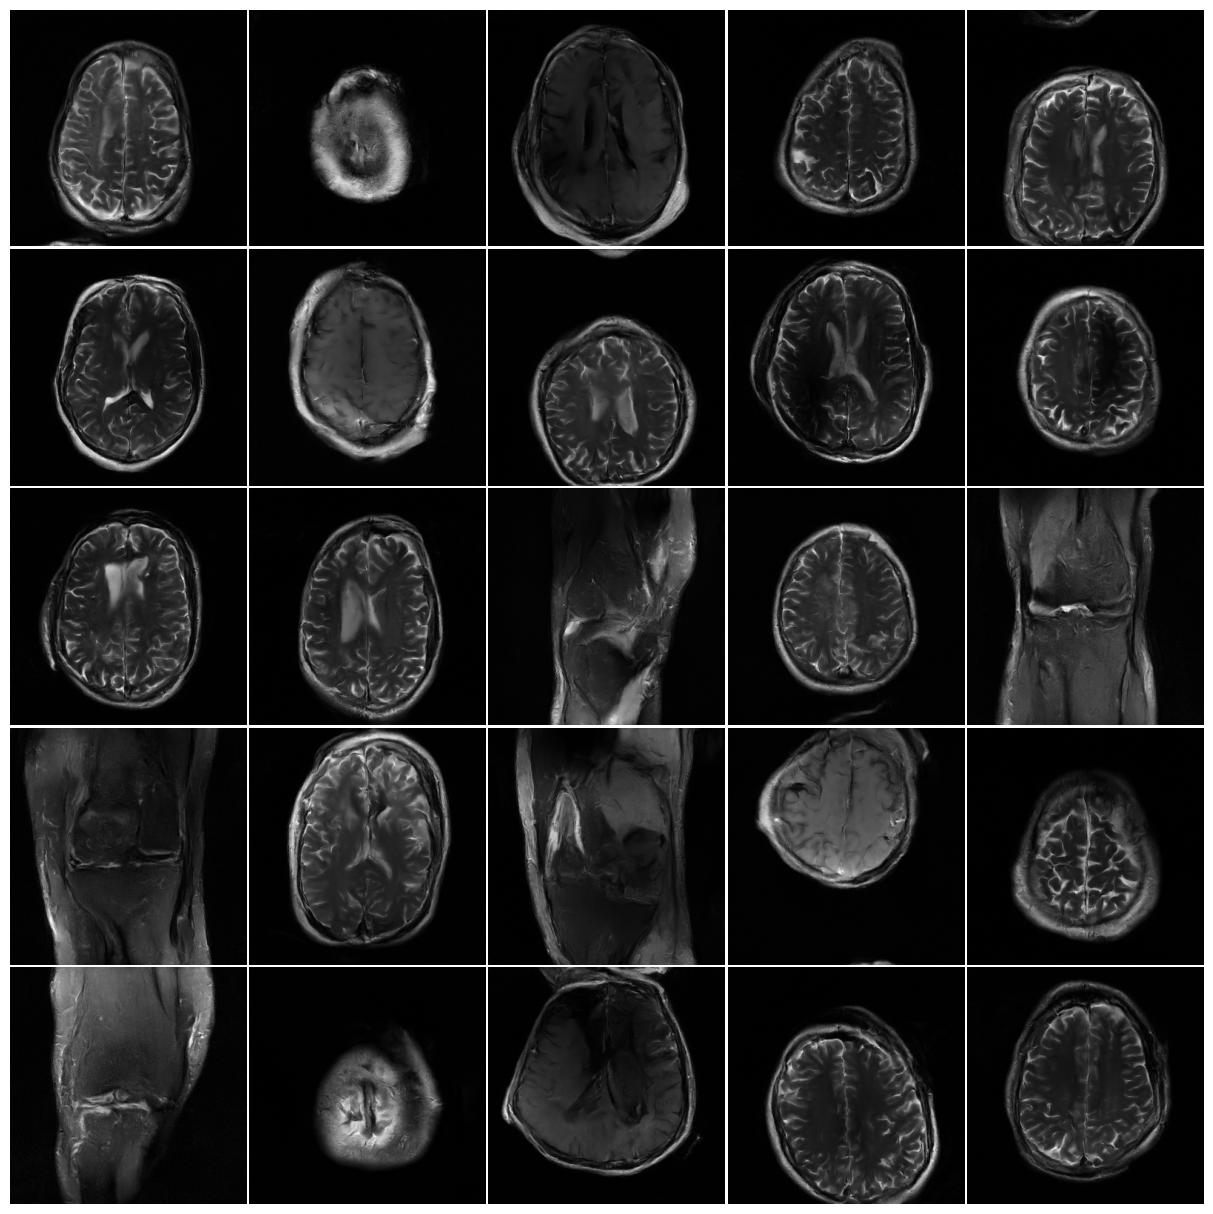

In [6]:
plt.figure(figsize=(12,12))
for i in range(25):

    plt.subplot(5,5,i+1)
    plt.imshow(np.flipud(abs(cplx_imgs[i])),cmap='gray')
    plt.axis('off')
    
plt.tight_layout(pad=0.2)

In [8]:
# img_num = 0
# plt.figure(figsize=(4,8))
# for i in range(18):
#     plt.subplot(6,3,i+1)
#     plt.imshow(np.flipud(abs(img_stack_cplx[i,img_num,...])),cmap='gray')
#     plt.axis('off')

# plt.tight_layout(pad=0.5)

